# Install Detectron2 & Setup


*   [Official Tutorial](https://colab.research.google.com/drive/1n1NzsJbB6zc53b7KE_vv234u507WZfKM?authuser=1#scrollTo=JgKyUL4pngvE)
*   [Face Detect Tutorial](https://colab.research.google.com/drive/1Jk4-qX9zdYGsBrTnh2vF52CV9ucuqpjk#scrollTo=eh6stJEoeTbG) ([vid](https://www.youtube.com/watch?v=8eLHZ0R5nHQ&t=580s&ab_channel=VenelinValkov), [blog](https://curiousily.com/posts/face-detection-on-custom-dataset-with-detectron2-in-python/))
*   [Official docs](https://detectron2.readthedocs.io/)







  # connect local
  `jupyter notebook    --NotebookApp.allow_origin='https://colab.research.google.com'    --port=8888    --NotebookApp.port_retries=0`

  stop local
  
  `jupyter notebook stop 8888`

In [ ]:
# local = True
# # !nvidia-smi
# !pip install torch torchvision
# import torch
# torch.cuda.is_available()
# print(torch.version.cuda)
# torch.version.cuda
# torch.__version__
# !python -c 'import torch; from torch.utils.cpp_extension import CUDA_HOME; print(torch.cuda.is_available(), CUDA_HOME)'

11.1
True /usr/local/cuda


## Install Detectron2

Run this first, then restart the runtime

In [ ]:
# wen replaced 2021/12/10
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html


## Setup Code


In [ ]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Need access to google drive and change GOOGLE_DRIVE_PATH_AFTER_MYDRIVE

data can be under 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')#, force_remount=True)

Mounted at /content/drive


In [ ]:
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ROB_535_self_driving_car/project'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))
# os.path.join(GOOGLE_DRIVE_PATH,"")


['rob535-fall2021-final-project-data', 'classes.csv', 'full_dataset.pkl', 'centroids.xlsx', '2D_bbox.csv', 'output', 'trainval_labels.csv', 'data', 'test_dir.csv', 'log.csv', 'ROB535_Task1', 'Image_Cartype_Detectron2']
drive  sample_data


### Import some common libraries

In [ ]:
from google.colab.patches import cv2_imshow

import torch, torchvision
import glob
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import csv
%matplotlib inline
# %config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# RANDOM_SEED = 42
# np.random.seed(RANDOM_SEED)
# torch.manual_seed(RANDOM_SEED)



In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode



# Data Formatting


## Read csv

In [ ]:
def rd_csv(file= 'trainval_labels',folder = 'rob535-fall2021-final-project-data'):
  labels = []
  lll = ()
  full_dataset = []
  folder = 'data'
  # folder = 'rob535-fall2021-final-project-data'

  path_to_ann = os.path.join(GOOGLE_DRIVE_PATH,file+'.csv')

  if file == 'trainval_labels':
    with open(path_to_ann, newline='') as csvfile:
      spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
      i = 0
      for row in spamreader:
        i+=1
        data_dict = {}
        
          
        if i == 1:
          continue
        else:
          dir = row[0].split('/')
          here = dir[-1].replace('\\','/') 

          data_dict['img_path'] = os.path.join(GOOGLE_DRIVE_PATH,folder,here+'_image.jpg')
          data_dict['guid'] = here
          label = int(row[1])
          
          if label<16:
            label = label-1
          elif label <20:
            label = label -2
          else:
            label = label -3
          labels.append(label)
          data_dict['label'] = label
          bbox = np.array((row[2:]))
          bbox2 = bbox.astype(np.float)

          data_dict['bbox'] = bbox2
          full_dataset.append(data_dict)
        # if i == 6500:
        #   break

    n = len(full_dataset)
    
    labels = list( dict.fromkeys(labels) )
    # print(len(labels))
    # print(full_dataset[0])
    return full_dataset
  else:
    with open(path_to_ann, newline='') as csvfile:
      spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
      i = 0
      for row in spamreader:
        i+=1
        data_dict = {}
        guid = row[0].split('\\')
        image = guid[-1].split('_')[0]
        guid = guid[-2]
        # guid/image,label
        # 0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0009,2
        
        data_dict['img_path'] = os.path.join(GOOGLE_DRIVE_PATH,folder,'test',guid,image+'_image.jpg')
        data_dict['guid'] = guid+'/'+image
        full_dataset.append(data_dict)

    return full_dataset
full_dataset = rd_csv()
test_dataset = rd_csv('test_dir')

# print(full_dataset[0]['bbox']+1)


## No need to run
###Run a pre-trained

No need to run


In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)


KeyboardInterrupt: ignored

### Visualize

No need to run 

In [ ]:
path = os.path.join(GOOGLE_DRIVE_PATH,'rob535-fall2021-final-project-data','trainval','0cec3d1f-544c-4146-8632-84b1f9fe89d3','0000_image.jpg')
path = 'drive/My Drive/ROB_535_self_driving_car/project/rob535-fall2021-final-project-data/trainval/047b864f-0753-448b-9483-f990ae41abaf/0020_image.jpg'
print(path)
im = cv2.imread(path)
# cv2_imshow(im)
outputs = predictor(im)
print(outputs["instances"].pred_classes)
# 2-9 --> 1-8
print(outputs["instances"].pred_boxes)

drive/My Drive/ROB_535_self_driving_car/project/rob535-fall2021-final-project-data/trainval/047b864f-0753-448b-9483-f990ae41abaf/0020_image.jpg


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

## Convert to proper format

*   [coco](https://cocodataset.org/#format-data)
*   [Detectron2](https://detectron2.readthedocs.io/tutorials/datasets.html)




###Use this to remove old datasetcatalog
No need to run the first time around,need to run for the second time onward (to fix the dataset already exist error)


In [ ]:
DatasetCatalog.remove("car_train")
DatasetCatalog.remove("car_val")
MetadataCatalog.remove("car_train")
MetadataCatalog.remove("car_val")
DatasetCatalog
# statement_metadata.name

DatasetCatalog(registered datasets: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_minival_100, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2014_minival_100, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_se

### Start from here for this subsection

In [ ]:
from detectron2.structures import BoxMode

def get_car_dicts(d, n):
  # with open(os.path.join(GOOGLE_DRIVE_PATH,'full_dataset.pkl'), 'rb') as f:
  #   full_dataset = pickle.load(f)
  full_dataset = rd_csv()
  if d =="train":
    imgs_anns = full_dataset[:n]
  elif d == "val":
    imgs_anns = full_dataset[n:]
   
  else:
    print('wrong d')

  dataset_dicts = []
  for idx, v in enumerate(imgs_anns):
      record = {}
      
      filename = v["img_path"]
      # height, width = cv2.imread(filename).shape[:2]
      
      record["file_name"] = filename
      record["image_id"] = idx
      record["height"] = 1052 #height
      record["width"] = 1914 #width
    
      # annos = v["regions"]
      objs = []
      # for _, anno in annos.items():
        # assert not anno["region_attributes"]
        # anno = anno["shape_attributes"]
        # px = anno["all_points_x"]
        # py = anno["all_points_y"]
        # poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
        # poly = [p for x in poly for p in x]

      obj = {
          "bbox": v['bbox'],
          # "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
          "bbox_mode": BoxMode.XYXY_ABS,
          # "segmentation": [poly],
          "category_id": v['label'],
      }
      objs.append(obj)
      record["annotations"] = objs
      dataset_dicts.append(record)
  return dataset_dicts
n = -1


for d in ["train", "val"]:
    DatasetCatalog.register("car_" + d, lambda d=d: get_car_dicts(d,n))
    MetadataCatalog.get("car_" + d).set(thing_classes=['Compacts', 'Sedans', 'SUVs', 'Coupes',
    'Muscle', 'SportsClassics', 'Sports', 'Super', 'Motorcycles',
    'OffRoad', 'Industrial', 'Utility', 'Vans', 'Cycles',
    'Boats', 'Planes', 'Service', 'Emergency',
    'Commercial', 'Trains'])

#['Unknown', 'Compacts', 'Sedans', 'SUVs', 'Coupes',
    # 'Muscle', 'SportsClassics', 'Sports', 'Super', 'Motorcycles',
    # 'OffRoad', 'Industrial', 'Utility', 'Vans', 'Cycles',
    # 'Boats', 'Helicopters', 'Planes', 'Service', 'Emergency',
    # 'Military', 'Commercial', 'Trains'])
car_metadata = MetadataCatalog.get("car_train")

### verify if bbox is correct

No need to run

In [ ]:
dataset_dicts = get_car_dicts("train",n)
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=car_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

We convert every annotation row to a single record with a list of annotations. You might also notice that we're building a polygon that is of the exact same shape as the bounding box. This is required for the image segmentation models in Detectron2.

You'll have to register your dataset into the dataset and metadata catalogues

# Training

In [ ]:
class CocoTrainer(DefaultTrainer):
  
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

## Config File

Config Reference can be found [here](https://detectron2.readthedocs.io/modules/config.html#config-references).


In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("car_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml") 
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 1e-3  
cfg.SOLVER.MAX_ITER = 80000    
cfg.SOLVER.STEPS = (55000,65000,75000)
cfg.SOLVER.GAMMA = 0.2        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128    
cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.CHECKPOINT_PERIOD = 5000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 20 

cfg.OUTPUT_DIR = os.path.join(GOOGLE_DRIVE_PATH,"output")
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 0
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ()
  TRAIN: ('car_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 'res3', 'res4', 'res5'

## Time to train


In [ ]:
tb_path = os.path.join(GOOGLE_DRIVE_PATH,"output")
print(tb_path)
%load_ext tensorboard
%tensorboard --logdir='drive/My Drive/ROB_535_self_driving_car/project/output'
# %reload_ext tensorboard
# !kill 382

drive/My Drive/ROB_535_self_driving_car/project/output


<IPython.core.display.Javascript object>

In [23]:
CUDA_LAUNCH_BLOCKING = "1"
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[12/15 20:07:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[12/15 20:08:31 d2.utils.events]:  eta: 9:26:59  iter: 55019  total_loss: 0.2214  loss_cls: 0.05338  loss_box_reg: 0.1388  loss_rpn_cls: 0.0006076  loss_rpn_loc: 0.003623  time: 1.3684  data_time: 0.8615  lr: 0.0002  max_mem: 3771M
[12/15 20:08:59 d2.utils.events]:  eta: 9:20:48  iter: 55039  total_loss: 0.1695  loss_cls: 0.03413  loss_box_reg: 0.1263  loss_rpn_cls: 0.0005579  loss_rpn_loc: 0.002058  time: 1.3654  data_time: 0.8549  lr: 0.0002  max_mem: 3771M
[12/15 20:09:26 d2.utils.events]:  eta: 9:20:22  iter: 55059  total_loss: 0.1598  loss_cls: 0.03501  loss_box_reg: 0.1312  loss_rpn_cls: 0.0002643  loss_rpn_loc: 0.001921  time: 1.3642  data_time: 0.8601  lr: 0.0002  max_mem: 3771M
[12/15 20:09:54 d2.utils.events]:  eta: 9:22:30  iter: 55079  total_loss: 0.1431  loss_cls: 0.02964  loss_box_reg: 0.1015  loss_rpn_cls: 0.0003714  loss_rpn_loc: 0.002111  time: 1.3671  data_time: 0.8607  lr: 0.0002  max_mem: 3771M
[12/15 20:10:21 d2.utils.events]:  eta: 9:22:23  iter: 55099  total_loss

# inference


## inference predictor

In [24]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)

## No need to run

### Visual first

Then, we randomly select several samples to visualize the prediction results.

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[{'bbox': array([ 508.31835692,  285.94519236, 1162.38118878,  831.22217369]), 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 1}]
tensor([1], device='cuda:0')


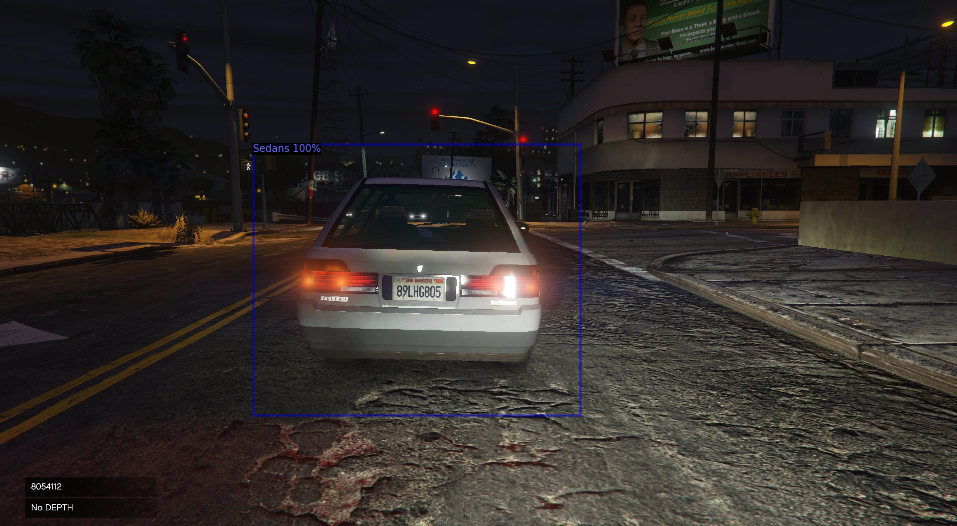

[{'bbox': array([1061.56401951,  340.81448909, 1365.03117918,  468.72494276]), 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 12}]
tensor([12, 12], device='cuda:0')


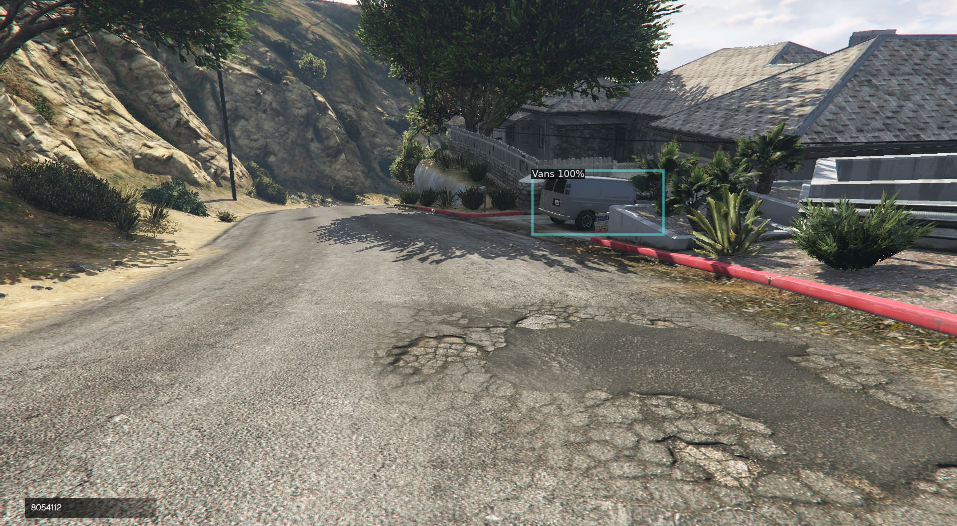

[{'bbox': array([363.04535634, 298.44553407, 560.57251934, 477.60608614]), 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 18}]
tensor([18], device='cuda:0')


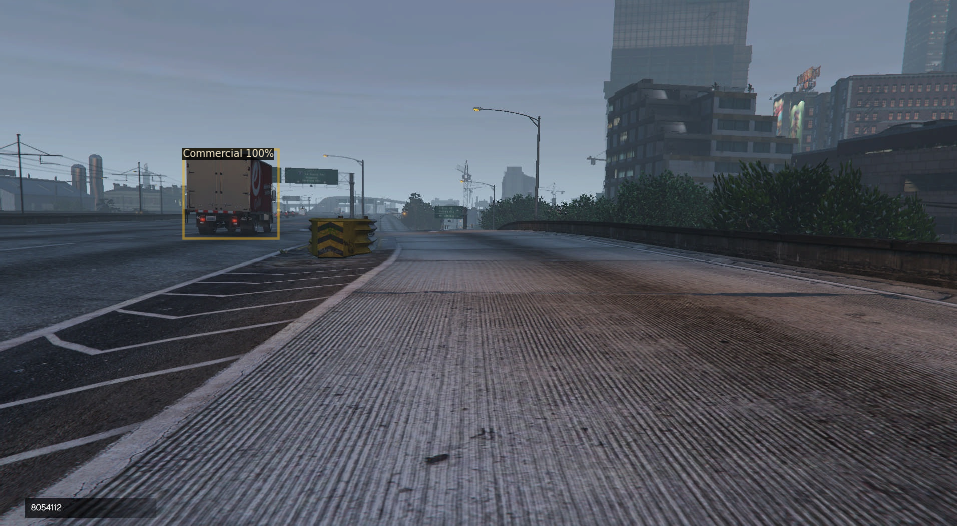

[{'bbox': array([676.6942992 , 376.4973321 , 833.3228575 , 486.18551607]), 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 11}]
tensor([11], device='cuda:0')


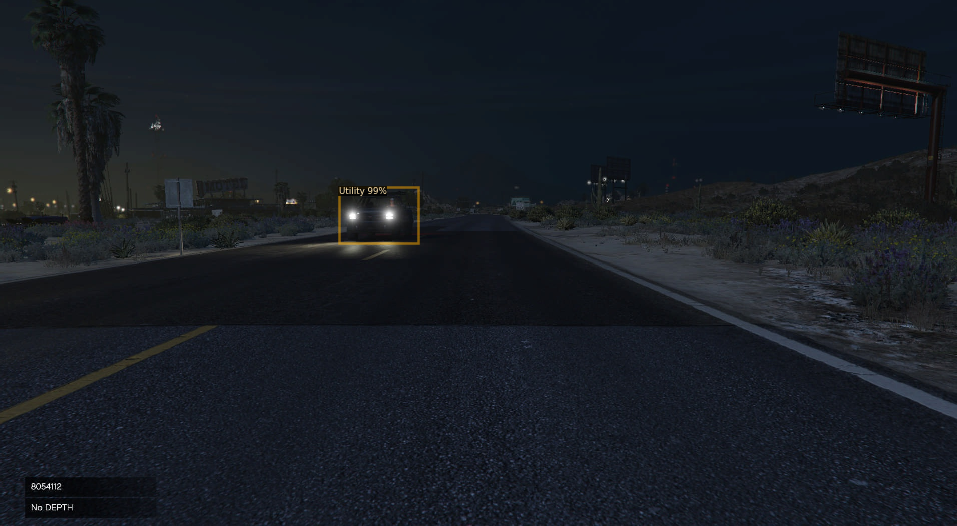

[{'bbox': array([552.46696367, 398.60372367, 698.59624341, 502.91588811]), 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2}]
tensor([2], device='cuda:0')


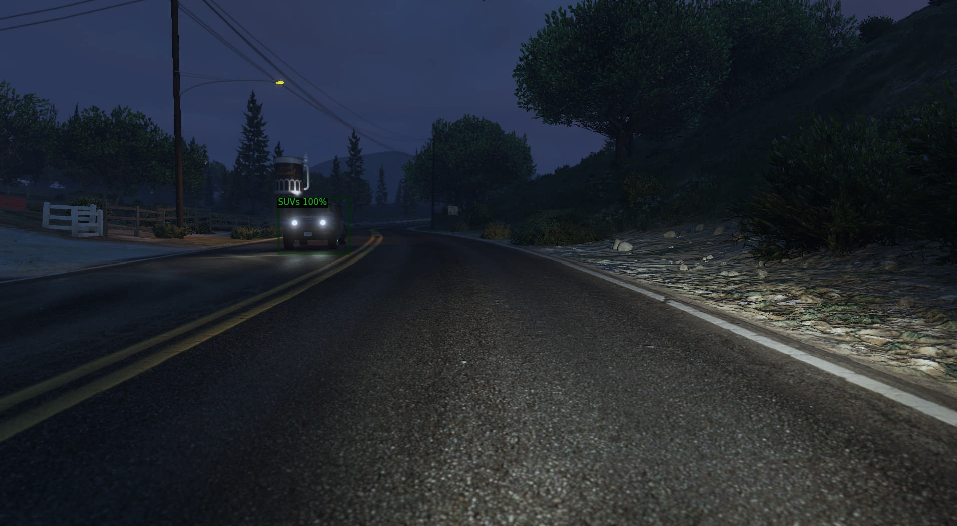

In [26]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_car_dicts('train',n)
# dataset_dicts = get_car_dicts('val',n)
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    print(d["annotations"])
    print(outputs["instances"].pred_classes)
    v = Visualizer(im[:, :, ::-1],
                   metadata=car_metadata, 
                   scale=0.5, 
                   
    )
    out = v.draw_instance_predictions(outputs["instances"][:1].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

###official evaluation for bbox ap
no need to run

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("car_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "car_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[12/12 17:10:29 d2.evaluation.coco_evaluation]: Trying to convert 'car_val' to COCO format ...
[12/12 17:10:29 d2.data.datasets.coco]: Converting annotations of dataset 'car_val' to COCO format ...)
[12/12 17:10:29 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[12/12 17:10:29 d2.data.datasets.coco]: Conversion finished, #images: 1073, #annotations: 1073
[12/12 17:10:29 d2.data.datasets.coco]: Caching COCO format annotations at './output/car_val_coco_format.json' ...
[12/12 17:10:29 d2.data.build]: Distribution of instances among all 20 categories:
|  category  | #instances   |  category  | #instances   |   category    | #instances   |
|:----------:|:-------------|:----------:|:-------------|:-------------:|:-------------|
|  Compacts  | 12           |   Sedans   | 128          |     SUVs      | 195          |
|   Coupes   | 170          |   Muscle   | 22           | SportsClass.. | 36           |
|   Sports   | 46           |   Super    | 21           |  Motorcycles

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/12 17:10:42 d2.evaluation.evaluator]: Inference done 11/1073. Dataloading: 0.4945 s/iter. Inference: 0.3584 s/iter. Eval: 0.0003 s/iter. Total: 0.8531 s/iter. ETA=0:15:06
[12/12 17:10:47 d2.evaluation.evaluator]: Inference done 19/1073. Dataloading: 0.3965 s/iter. Inference: 0.3599 s/iter. Eval: 0.0003 s/iter. Total: 0.7570 s/iter. ETA=0:13:17
[12/12 17:10:56 d2.evaluation.evaluator]: Inference done 25/1073. Dataloading: 0.6087 s/iter. Inference: 0.3645 s/iter. Eval: 0.0003 s/iter. Total: 0.9739 s/iter. ETA=0:17:00
[12/12 17:11:02 d2.evaluation.evaluator]: Inference done 33/1073. Dataloading: 0.5326 s/iter. Inference: 0.3649 s/iter. Eval: 0.0003 s/iter. Total: 0.8981 s/iter. ETA=0:15:34
[12/12 17:11:07 d2.evaluation.evaluator]: Inference done 41/1073. Dataloading: 0.4893 s/iter. Inference: 0.3640 s/iter. Eval: 0.0003 s/iter. Total: 0.8539 s/iter. ETA=0:14:41
[12/12 17:11:13 d2.evaluation.evaluator]: Inference done 49/1073. Dataloading: 0.4635 s/iter. Inference: 0.3632 s/iter. Eval:

# Output Results

## Store Output

set test = True

and this block will output the label for test set in output/output.csv


set test = False

and this block will output the label for eval set in output/eval_output.csv

In [27]:
output = [] 
test = True
if test:
  test_dataset = rd_csv('test_dir')
  nnn=len(test_dataset)
  for id, d in enumerate(test_dataset):    
      im = cv2.imread(d["img_path"])
      # print(d["img_path"])
      outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
      # print(d["annotations"])
      pred_list = outputs["instances"].pred_classes
      if len(pred_list) == 0:
        output.append([d['guid'],0,pred_list]) # 0 or 2
        continue
      pred = pred_list[0]
      print(id,'/',nnn, pred_list)
      if pred>13 or len(pred_list) == 0:
        output.append([d['guid'],0,pred_list])
      elif pred<8:
        output.append([d['guid'],1,pred_list])
      elif pred<14:
        output.append([d['guid'],2,pred_list])

      # if id>3:
      #   break
  print('writing')
  with open(os.path.join(GOOGLE_DRIVE_PATH,"output","output"+'.csv'), 'w', newline='') as csvfile:
      spamwriter = csv.writer(csvfile, delimiter=',',
                              quotechar='|', quoting=csv.QUOTE_MINIMAL)
      spamwriter.writerow(['guid/image','label'])
      for out in output:
        spamwriter.writerow(out[:2])

  with open(os.path.join(GOOGLE_DRIVE_PATH,"output","log"+'.csv'), 'w', newline='') as csvfile:
      spamwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
      spamwriter.writerow(['guid/image','label','pred'])
      for out in output:
        spamwriter.writerow(out)
else:
  eval_dataset = rd_csv()
  d='val'
  if d =="train":
    eval_dataset = eval_dataset[:n]
  elif d == "val":
    eval_dataset = eval_dataset[n:]
  nnn=len(eval_dataset)
  for id, d in enumerate(eval_dataset):    
      im = cv2.imread(d["img_path"])
      # print(d["img_path"])
      outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
      # print(d["annotations"])
      pred_list = outputs["instances"].pred_classes
      
      pred = d['label']
      if pred>13 or len(pred_list) == 0:
        gt_label = 0
      elif pred<8:
        gt_label = 1
      elif pred<14:
        gt_label = 2

      if len(pred_list) == 0:
        output.append([d['guid'],d['label'],0,pred_list]) # 0 or 2
        continue
      pred = pred_list[0]
      print(id,'/',nnn,d['label'], pred_list)
      if pred>13 or len(pred_list) == 0:
        output.append([d['guid'],gt_label,0,d['label'],pred_list])
      elif pred<8:
        output.append([d['guid'],gt_label,1,d['label'],pred_list])
      elif pred<14:
        output.append([d['guid'],gt_label,2,d['label'],pred_list])

      # if id>3:
      #   break
  print('writing')
  with open(os.path.join(GOOGLE_DRIVE_PATH,"output","eval_log"+'.csv'), 'w', newline='') as csvfile:
      spamwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
      spamwriter.writerow(['guid/image','gt_label','label','gt_pred','pred'])
      for out in output:
        spamwriter.writerow(out)
print('finished')

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


0 / 2631 tensor([16], device='cuda:0')
1 / 2631 tensor([16,  8], device='cuda:0')
2 / 2631 tensor([16], device='cuda:0')
3 / 2631 tensor([16], device='cuda:0')
4 / 2631 tensor([16], device='cuda:0')
5 / 2631 tensor([16], device='cuda:0')
6 / 2631 tensor([16], device='cuda:0')
7 / 2631 tensor([16], device='cuda:0')
8 / 2631 tensor([16,  8], device='cuda:0')
9 / 2631 tensor([12,  1, 10,  5,  2], device='cuda:0')
10 / 2631 tensor([1], device='cuda:0')
11 / 2631 tensor([1], device='cuda:0')
12 / 2631 tensor([1], device='cuda:0')
13 / 2631 tensor([1], device='cuda:0')
14 / 2631 tensor([1, 3, 2, 6], device='cuda:0')
15 / 2631 tensor([11], device='cuda:0')
17 / 2631 tensor([11, 18, 18], device='cuda:0')
18 / 2631 tensor([18, 11], device='cuda:0')
19 / 2631 tensor([18, 11], device='cuda:0')
20 / 2631 tensor([18, 11], device='cuda:0')
21 / 2631 tensor([18, 11, 11], device='cuda:0')
22 / 2631 tensor([18, 12, 11, 18, 11], device='cuda:0')
23 / 2631 tensor([18, 11,  9], device='cuda:0')
24 / 2631 

## temporal conv


In [28]:

import copy
for name in ['output','output_temp']:
  output = []
  with open(os.path.join(GOOGLE_DRIVE_PATH,"output",name+'.csv'),'r', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for idx,row in enumerate(spamreader):
      if idx ==0:
        continue
      output.append(row)
      # print(row)
  output_temp = copy.deepcopy(output)

  for id, out in enumerate(output):
    out = out[1]
    if id < 2 or id > len(output)-3:
      continue
    try:
      after = output[id+1][1]
      before = output[id-1][1]
      # print(id,out,before,after)
      if out ==after or out==before:
        output_temp[id][1] = out
        # print('...',end=',')
      else:
        if before == after:
          output_temp[id][1] = before
        elif output[id-2][1] == before and output[id-3][1] == before and output[id-4][1] == before:
          output_temp[id][1] = before
        elif output[id+2][1] == after and output[id+3][1] == after and output[id+4][1] == after:
          output_temp[id][1] = after
        elif output[id-2][1] == before and output[id-3][1] == before:
          output_temp[id][1] = before
        elif output[id+2][1] == after and output[id+3][1] == after:
          output_temp[id][1] = after
    except:
      pass

    print(output[id],end=',')
    print(output_temp[id][1])
  with open(os.path.join(GOOGLE_DRIVE_PATH,"output","output_temp"+'.csv'), 'w', newline='') as csvfile:
      spamwriter = csv.writer(csvfile, delimiter=',',
                              quotechar='|', quoting=csv.QUOTE_MINIMAL)
      spamwriter.writerow(['guid/image','label'])
      for out in output_temp:
        spamwriter.writerow(out[:2])

流式输出内容被截断，只能显示最后 5000 行内容。
['0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0043', '2'],2
['0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0044', '2'],2
['0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0045', '2'],2
['0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0046', '2'],2
['0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0047', '1'],1
['0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0048', '1'],1
['0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0049', '2'],1
['0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0050', '1'],1
['0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0051', '1'],1
['0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0052', '1'],1
['0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0053', '1'],1
['0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0054', '1'],1
['0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0055', '1'],1
['0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0056', '1'],1
['0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0057', '1'],1
['0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0058', '1'],1
['0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0059', '1'],1
['0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0060', '1'],1
['0ff0a23e-5f50-446